In [1]:
import warnings

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
%%capture

from ding0.core import NetworkDing0
from ding0.tools.logger import setup_logger
from ding0.tools.results import save_nd_to_pickle
from ding0.tools.plots import plot_mv_topology
from egoio.tools import db
from sqlalchemy.orm import sessionmaker
import oedialect

from ding0.tools import results # to load pickl file


# create new network
nd = NetworkDing0(name='network')


# set ID of MV grid district
mv_grid_districts = [40] # fn

In [3]:
import osmnx as ox

import networkx as nx 

import pandas as pd
from sqlalchemy import func              
from geoalchemy2.shape import to_shape 


from shapely.geometry import Point, Polygon, LineString



import folium

In [4]:
from config.config_lv_grids_osm import get_config_osm
from config.db_conn_local import create_session_osm 

from grid.lv_grid.routing import build_graph_from_ways, \
get_location_substation_at_pi, subdivide_graph_edges, \
get_mvlv_subst_loc_list, get_cluster_graph_and_nodes, \
add_mv_load_station_to_mvlv_subst_list

from grid.lv_grid.geo import convertCoords

from grid.lv_grid.parameterization import parameterize_by_load_profiles
#from grid.lv_grid.clustering import 

from grid.lv_grid.geo import get_Point_from_x_y, get_points_in_load_area, \
get_convex_hull_from_points

#### SET DING0 SETTINGS

In [5]:
# TODO set in config file
ding0_default=False
retain_all=False #  weil sonst graphen außerhalb des polys unverbunden zum graphen beibehalten werden

In [6]:
engine = db.connection(section='oedb_dialect', readonly=True)
session = sessionmaker(bind=engine)()

In [7]:
%%time

print('ding0_default', ding0_default)
if ding0_default:
    
    lv_stations, lv_grid_districts = nd.import_mv_grid_districts(session, mv_grid_districts_no=mv_grid_districts)

else:
    
    id_db, row, simp_graph, geo_load_area, buildings_w_loads_df, street_loads = nd.import_mv_grid_districts(
        session, ding0_default, mv_grid_districts_no=mv_grid_districts)
    
    #d_db, row, simp_graph, geo_load_area, buildings_w_loads_df, street_loads = nd.import_mv_grid_districts(
    #    session, ding0_default, mv_grid_districts_no=mv_grid_districts)

ding0_default False
Begin topologically simplifying the graph...
Simplified graph: 162 to 108 nodes, 328 to 220 edges
Wall time: 6.32 s


### clustering

In [8]:
from grid.lv_grid.clustering import get_cluster_numbers, apply_AgglomerativeClustering

In [9]:
%%time

n_cluster = get_cluster_numbers(buildings_w_loads_df)

clustering_successfully=False
for i in range(len(simp_graph.nodes)):
    
    # increment n_cluster. n_cluster += 1
    labels = apply_AgglomerativeClustering(simp_graph, n_cluster)
    
    cluster_graph, nodes_w_labels = get_cluster_graph_and_nodes(simp_graph, labels)
    mvlv_subst_list = get_mvlv_subst_loc_list(cluster_graph, nodes_w_labels, street_loads, labels, n_cluster)
    
    if len(mvlv_subst_list) > 0:
        
        print('all clusters are in range')
        
        clustering_successfully=True
        break
        
    else:
        
        n_cluster += 1
        print('n_cluster', n_cluster)
        print('at least one node trespasses dist to substation')
        
if not clustering_successfully:
    
    print('clustering cannot ensure dist from substation to each node <= threshold')

all clusters are in range
Wall time: 213 ms


In [10]:
%%time


# get loadds on mv level
#mv_lv_level_threshold = get_config_osm('mv_lv_threshold_capacity')
# TODO weg mit den 40 wg testing
mv_lv_level_threshold = 40

loads_mv_df = buildings_w_loads_df.loc[buildings_w_loads_df.capacity >= mv_lv_level_threshold]

#assign cluster id to loads on mv level
mv_cluster_ids = list(range(n_cluster, n_cluster + len(loads_mv_df)))
loads_mv_df['cluster'] = mv_cluster_ids


# map cluster to buildings of lv level
buildings_w_loads_df = buildings_w_loads_df[~buildings_w_loads_df.index.isin(loads_mv_df.index.tolist())]
buildings_w_loads_df['cluster'] = buildings_w_loads_df.nn.map(nodes_w_labels.cluster)


# concat lv and mv level after assignment of cluster ids
buildings_w_loads_df = pd.concat([buildings_w_loads_df, loads_mv_df])

mvlv_subst_list = add_mv_load_station_to_mvlv_subst_list(loads_mv_df, mvlv_subst_list, nodes_w_labels)

Wall time: 72.5 ms


In [11]:
from shapely.geometry import Point # , shape
from grid.lv_grid.geo import get_points_in_load_area, get_convex_hull_from_points

In [12]:
from ding0.core.structure.regions import LVGridDistrictDing0

In [17]:
%%time


# init empty stations_df
lv_stations = pd.DataFrame(columns=['la_id', 'geom', 'load_level'])
lv_stations.index.name = 'mvlv_subst_id'

load_area_ding0_districts_list = []

# init empty districts_df
#lv_grid_districts = pd.DataFrame(columns=['la_id', 'peak_load', 'geom', 'load_level'])
#lv_grid_districts.index.name = 'mvlv_subst_id'

# add stations for cluster load centers
last_row_ix = len(lv_stations)
for mvlv_subst_loc in mvlv_subst_list:
    
    cluster_id = mvlv_subst_loc.get('cluster') 
    load_level = mvlv_subst_list[cluster_id].get('load_level')
    
    # get convex hull per cluster
    buildings = buildings_w_loads_df.loc[buildings_w_loads_df.cluster==cluster_id]
    cluster_geo_list = buildings.geometry.tolist()  # geo of building
    
    
    if load_level == 'mv':
        
        cluster_geo_list+= buildings.nn_coords.tolist() # geo of location of substation

    points = get_points_in_load_area(cluster_geo_list)

    polygon = get_convex_hull_from_points(points)
        
    # build station
    lv_stations.loc[last_row_ix+cluster_id] = [id_db, Point(mvlv_subst_loc.get('x'),mvlv_subst_loc.get('y')), load_level]
    
    lvgriddistrict = LVGridDistrictDing0(mvlv_subst_id=last_row_ix+cluster_id, 
                                         graph_district=mvlv_subst_loc.get('graph_district'), 
                                         buildings_district=buildings, id_db=id_db, 
                                         peak_load=buildings.capacity.sum(), geom=polygon, 
                                         load_level=load_level)

    load_area_ding0_districts_list.append(lvgriddistrict)
    

Wall time: 98.9 ms


C:\Users\Robert\anaconda3\envs\ox\lib\site-packages\pandas\core\dtypes\cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


In [18]:
load_area_ding0_districts_list

[lv_grid_district_5588, lv_grid_district_5588]

In [20]:
load_area_ding0_districts_list[0].buildings

,category,area,geometry,raccordement_building,name,number_households,n_amenities_inside,osm_id_building,geometry_amenity,x,y,capacity,nn,nn_dist,nn_coords,cluster
238921207,residential,314.1560,"POLYGON ((4282028.003669901 2732392.139527212,...",POINT (4282035.774356561 2732393.849467995),None,1.0,1.0,NaN,NaN,4.282036e+06,2.732394e+06,1.70847,2467314133,22.407606,POINT (4282036.799621603 2732371.46533008),0
238921686,residential,1346.3200,"POLYGON ((4281980.692153729 2732381.304170885,...",POINT (4281994.589535575 2732395.048516899),None,1.0,1.0,NaN,NaN,4.281995e+06,2.732395e+06,1.70847,52077343701,18.771823,POINT (4281998.127038708 2732413.484010151),0
238921687,residential,468.8540,"POLYGON ((4281962.613441726 2732395.276549237,...",POINT (4281969.182927253 2732404.4451686),None,1.0,1.0,NaN,NaN,4.281969e+06,2.732404e+06,1.70847,52077343702,17.470195,POINT (4281978.746977324 2732419.064903602),0
259193856,house,286.2590,"POLYGON ((4282100.071614176 2732469.773103668,...",POINT (4282106.887997673 2732473.841958479),None,1.0,1.0,NaN,NaN,4.282107e+06,2.732474e+06,1.70847,331517312,19.524409,POINT (4282097.601820472 2732456.667283475),0
259193857,residential,68.4243,"POLYGON ((4282093.324943689 2732468.253572233,...",POINT (4282096.449473034 2732471.822196446),None,1.0,1.0,NaN,NaN,4.282096e+06,2.732472e+06,1.70847,331517312,15.198661,POINT (4282097.601820472 2732456.667283475),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626715616,residential,201.7430,"POLYGON ((4282442.319053043 2732378.670285587,...",POINT (4282447.422125325 2732383.690767293),None,1.0,1.0,NaN,NaN,4.282447e+06,2.732384e+06,1.70847,331517302,28.785365,POINT (4282458.685381616 2732410.181073276),0
626715617,residential,373.8330,"POLYGON ((4282424.21033108 2732351.627500165, ...",POINT (4282432.331268933 2732356.4714533),None,1.0,1.0,NaN,NaN,4.282432e+06,2.732356e+06,1.70847,331517282,39.473487,POINT (4282463.681514776 2732332.485659896),0
626715618,residential,646.0440,"POLYGON ((4282432.679437034 2732343.512610075,...",POINT (4282447.617693484 2732340.478627478),None,1.0,1.0,NaN,NaN,4.282448e+06,2.732340e+06,1.70847,331517282,17.942516,POINT (4282463.681514776 2732332.485659896),0
785560938,house,316.3000,"POLYGON ((4282232.505216478 2732419.566322969,...",POINT (4282240.115550136 2732423.30237199),None,1.0,1.0,NaN,NaN,4.282240e+06,2.732423e+06,1.70847,368956408301,15.049898,POINT (4282236.011947231 2732437.782008585),0


In [16]:
lv_stations

,la_id,geom,load_level
mvlv_subst_id,,,
0,5588,POINT (4282131.446189347 2732430.592609585),lv
1,5588,POINT (4282194.306080293 2732456.635486355),mv


In [12]:
lv_grid_districts.head(2)

,la_id,population,peak_load_residential,peak_load_retail,peak_load_industrial,peak_load_agricultural,peak_load,geom,sector_count_residential,sector_count_retail,sector_count_industrial,sector_count_agricultural,sector_consumption_residential,sector_consumption_retail,sector_consumption_industrial,sector_consumption_agricultural
mvlv_subst_id,,,,,,,,,,,,,,,,
419093,5372,10.0,3.493570,0.0,0.0,99.525989,103.019559,MULTIPOLYGON(((9.44476423426424 47.69930354485...,0.0,0.0,0.0,2.0,16346.482102,0.0,0.0,414070.515734
420154,4830,3.0,1.048071,0.0,0.0,0.000000,1.048071,MULTIPOLYGON(((9.49954883830014 47.68339565373...,1.0,0.0,0.0,0.0,4903.944631,0.0,0.0,0.000000


In [ ]:
# additionally for object
# lv_grid as lv_grid-Obect

# df
la_id
population
peak_load_residential
peak_load_retail
peak_load_industrial
peak_load_agricultural
peak_load
geom
sector_count_residential
sector_count_retail
sector_count_industrial
sector_count_agricultural
sector_consumption_residential
sector_consumption_retail
sector_consumption_industrial
sector_consumption_agricultural

In [15]:
# district e.g.
'id_db': 4563,
'geo_data': <shapely.geometry.multipolygon.MultiPolygon at 0x17ffc430160>,
'lv_load_area': lv_load_area_4544,
'lv_grid': lv_grid_4563,
'population': 80,
'peak_load_residential': 27.9485612387548,
'peak_load_retail': 0.0,
'peak_load_industrial': 0.0,
'peak_load_agricultural': 0.0,
'peak_load': 27.9485612387548,
'sector_count_residential': 1,
'sector_count_retail': 0,
'sector_count_industrial': 0,
'sector_count_agricultural': 0,
'sector_consumption_residential': 130771.856816184,
'sector_consumption_retail': 0.0,
'sector_consumption_industrial': 0.0,
'sector_consumption_agricultural': 0.0

,category,area,geometry,raccordement_building,name,number_households,n_amenities_inside,osm_id_building,geometry_amenity,x,y,capacity,nn,nn_dist,nn_coords
443340114,restaurant,732.547,"POLYGON ((9.483392699999998 47.70459640000707,...",POINT (9.48352605 47.70469195000704),Sportplatz-Restaurant,1.0,1.0,301431136.0,0101000020e6100000c3d3861e8cf72240da9a83ea30da...,9.483526,47.704692,67.035376,443338172,29.025206,POINT (9.483255199999999 47.70450509625661)


In [ ]:
# todo check if truncate creates subgrpahs
# if len(subgraphs) > 1:
    # there are unconnected subgraphs
    # then for each subgraph
        # cluserting
        # for each cluster
            # build lv_grid_district

### Clustering

In [27]:
n_clusters = get_n_cluster(buildings_w_loads_df)
if n_clusters < len(fn_fallenbrunnen_la._lv_grid_districts):
    n_clusters = len(fn_fallenbrunnen_la._lv_grid_districts)
buildings_w_loads_df = cluster_k_means(buildings_w_loads_df, n_clusters)

In [29]:
n_clusters

3

### Update and add _districts

In [30]:
for i in range(n_clusters):
    
    print(len(buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==i)]))


99
85
79


In [28]:
buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)]

,category,capacity,area,number_households,x,y,geometry,raccordement,nn,nn_dist,Cluster
osm_id,,,,,,,,,,,
8598838279,ice_cream,20.966863,229.121,0.645161,9.437183,47.674769,"POLYGON ((9.437094099999998 47.67477800001394,...",POINT (9.437183076702567 47.67476938145773),475940044,19.021132,0
144020300,public_building,244.695822,2113.09,0.8125,9.438239,47.675506,"POLYGON ((9.437905999999998 47.67551250001376,...",POINT (9.438238891069723 47.67550616796044),1576023053,34.831012,0
144023114,school,102.108142,1641.61,0.552632,9.438521,47.673818,"POLYGON ((9.438203599999998 47.67375600001416,...",POINT (9.438521488700175 47.67381754064048),68844093,33.677840,0
314909001,residential,1.246721,100,0.72973,9.43711,47.674319,"POLYGON ((9.4370154 47.67431780001401, 9.43711...",POINT (9.437109750000001 47.67431900001404),2080880814,14.638173,0
314909020,house,1.102239,100,0.645161,9.437548,47.674401,"POLYGON ((9.4374646 47.674413400014, 9.4375446...",POINT (9.437548450000001 47.67440130001403),314975344,15.374000,0
...,...,...,...,...,...,...,...,...,...,...,...
314913916,residential,2.904399,100,1.7,9.436301,47.672468,"POLYGON ((9.436173800000001 47.67246730001447,...",POINT (9.436301343479869 47.67246766666069),311379901,30.431139,0
338514542,school,407.558658,6552.39,0.594203,9.438414,47.673881,"POLYGON ((9.437957300000001 47.67387860001414,...",POINT (9.438414351486788 47.67388107322754),68844093,31.901109,0
401560706,residential,1.102239,100,0.645161,9.43769,47.674448,"POLYGON ((9.4376228 47.674467300014, 9.4377058...",POINT (9.437690147469656 47.67444791593603),314975344,27.030240,0


In [16]:
%%time

geometry = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0), 'geometry'].tolist()

points = get_points_in_load_area(geometry)
        
len(points)

Wall time: 9.38 ms


140

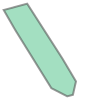

In [17]:
get_convex_hull_from_points(points)

In [24]:
fn_fallenbrunnen_la.lv_load_area_group.__dict__

{'id_db': 20,
 'mv_grid_district': mv_grid_district_40,
 '_lv_load_areas': [lv_load_area_4544,
  lv_load_area_4545,
  lv_load_area_4548,
  MVCableDist_mvgd_40_26],
 'peak_load': 65.35928151751943,
 'branch_length_sum': 0,
 'peak_load_max': 1000.0,
 'branch_length_max': 2000.0,
 'root_node': MVCableDist_mvgd_40_23}

In [28]:
nd._mv_grid_districts[0].__dict__

{'id_db': 40,
 'mv_grid': mv_grid_40,
 '_lv_load_areas': [lv_load_area_2128,
  lv_load_area_2292,
  lv_load_area_2383,
  lv_load_area_2520,
  lv_load_area_2521,
  lv_load_area_2561,
  lv_load_area_2608,
  lv_load_area_2625,
  lv_load_area_2633,
  lv_load_area_2705,
  lv_load_area_2728,
  lv_load_area_2763,
  lv_load_area_2765,
  lv_load_area_2840,
  lv_load_area_2842,
  lv_load_area_3029,
  lv_load_area_3088,
  lv_load_area_3089,
  lv_load_area_3119,
  lv_load_area_3160,
  lv_load_area_3235,
  lv_load_area_3277,
  lv_load_area_3304,
  lv_load_area_3305,
  lv_load_area_3307,
  lv_load_area_3311,
  lv_load_area_3314,
  lv_load_area_3403,
  lv_load_area_3413,
  lv_load_area_3645,
  lv_load_area_3661,
  lv_load_area_3731,
  lv_load_area_3780,
  lv_load_area_3805,
  lv_load_area_3911,
  lv_load_area_3986,
  lv_load_area_3987,
  lv_load_area_3992,
  lv_load_area_4212,
  lv_load_area_4337,
  lv_load_area_4347,
  lv_load_area_4487,
  lv_load_area_4488,
  lv_load_area_4544,
  lv_load_area_4545,

In [17]:
fn_fallenbrunnen_la._lv_grid_districts[0].lv_grid._station.__dict__

{'id_db': 4563,
 'geo_data': <shapely.geometry.point.Point at 0x118800eba90>,
 'grid': lv_grid_4563,
 '_transformers': [Transformer_lv_grid_4563_1],
 'v_level_operation': None,
 'lv_load_area': lv_load_area_4544,
 'voltage_res': [0.9897135909377942, 1.0123145234795161]}

In [17]:
preprocessed_clusters = []   
    

for cluster_id in range(n_clusters):
    
    if cluster_id < len(fn_fallenbrunnen_la._lv_grid_districts):
        
        print('delete or update _lv_grid_districts[', cluster_id, ']')
        
        # GET NEW VALUES FOR DISTRICT        
        # get convex hull of cluster
        points = get_points_in_load_area(buildings_w_loads_df.loc[buildings_w_loads_df['Cluster']==cluster_id])
        district_convex_hull = get_convex_hull_from_points(points)
        
        # get location of substation for cluster
        station_x, station_y = get_location_substation_at_pi(graph, buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)])

        
        # UPDATE VALUES
        # update values of _lv_grid_districts[cluster_id]
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].geo_data  = district_convex_hull
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].poulation = buildings_w_loads_df.loc[buildings_w_loads_df['Cluster']==cluster_id]['number_households'].sum()
        
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].peak_load = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)]['capacity'].sum()
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].peak_load_residential = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==cluster_id) & buildings_w_loads_df['number_households'] > 0]['capacity'].sum()
        
        
        # ADD / RESET DING0 ELEMENTS
        # update position of substation
        fn_fallenbrunnen_la._lv_grid_districts[0].lv_grid._station.geo_data = get_Point_from_x_y(station_x, station_y)
        
        # reset list to add new elements
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].lv_grid._station.transformers.clear()
        
        
        # update trafo and loads
        #fn_fallenbrunnen_la._lv_grid_districts[cluster_id].lv_grid.build_grid()
        
        
    else:
        
        print('add _lv_grid_districts id', cluster_id)
        
        
        
        
        
    break
    

update _lv_grid_districts 0
add _lv_grid_districts id 1
add _lv_grid_districts id 2


In [21]:
fn_fallenbrunnen_la._lv_grid_districts[0].lv_grid._station.__dict__

{'id_db': 4563,
 'geo_data': <shapely.geometry.point.Point at 0x1d50cd257f0>,
 'grid': lv_grid_4563,
 '_transformers': [Transformer_lv_grid_4563_1],
 'v_level_operation': None,
 'lv_load_area': lv_load_area_4544,
 'voltage_res': [0.9897135909377942, 1.0123145234795161]}

In [19]:
#lv_district_of_interest.lv_grid.graph_draw(mode='LV')

In [16]:
lv_district_of_interest.lv_grid.__dict__ # .geo_data.wkt

NameError: name 'lv_district_of_interest' is not defined

In [19]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

In [20]:
X = []    # collect nodes

for node in graph.nodes:

    X.append([graph.nodes[node]['X'], graph.nodes[node]['Y']])
    
    
X = np.array(X)



# clustering

adj_mat_sparse = nx.adjacency_matrix(graph, weight='length')

clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=adj_mat_sparse).fit(X)






# assign cluster labels

i_label = 0

for node in list(graph.nodes):

    graph.nodes[node]['cluster'] = clustering.labels_[i_label]
    
    i_label += 1
    
labels = nx.get_node_attributes(graph, 'cluster') 

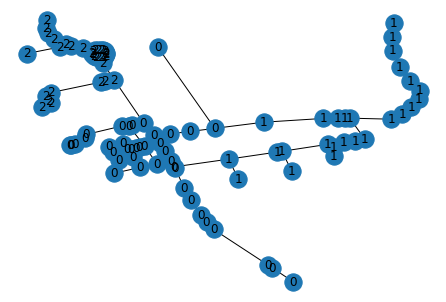

In [23]:
nx.draw(graph, node_coords_dict,labels=labels)

In [24]:
X = []    # collect nodes

for node in graph.nodes:

    X.append([graph.nodes[node]['X'], graph.nodes[node]['Y']])
    
    
X = np.array(X)



# clustering

adj_mat_sparse = nx.to_numpy_matrix(graph, weight='length')

clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=adj_mat_sparse).fit(X)






# assign cluster labels

i_label = 0

for node in list(graph.nodes):

    graph.nodes[node]['cluster'] = clustering.labels_[i_label]
    
    i_label += 1
    
labels = nx.get_node_attributes(graph, 'cluster') 

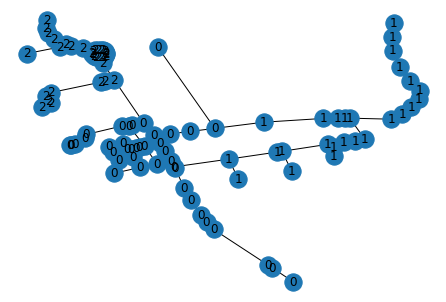

In [25]:
nx.draw(graph, node_coords_dict,labels=labels)